Independent adenovirus-based assay experimental validation of 17k enhancer locations in H1 cells

~/liftOver H1.17k.enhancer.hg19.tsv ~/hg19ToHg38.over.chain H1.17k.enhancer.hg38.mapped.bed H1.17k.enhancer.hg38.umapped.bed

In [1]:
#common python packages
import numpy as np
import pandas as pd
import string
import random
import os
import pickle
import argparse
import wget
import math
import matplotlib.pyplot as plt
from datetime import datetime

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig


#machine learning packages
import sklearn
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

import tensorflow as tf
from tensorflow.python.framework import ops

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v3 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

import cv2

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/gpf

In [2]:
exp_file_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/Sutton/"
exp_file = exp_file_dir + "H1.17k.enhancer.hg38.mapped.bed"
H1_sites = pybedtools.BedTool(exp_file)
print(H1_sites.head(as_string=True))
print("Element Count: ", H1_sites.count())
interval_lengths = [len(i) for i in H1_sites]
print("Element Lengths: ", interval_lengths)

chr1	29047	33538	chr1:29048-33538	1
chr1	626420	630676	chr1:561801-566056	1
chr1	631239	635733	chr1:566620-571113	1
chr1	729892	736411	chr1:665273-671791	1
chr1	885521	890696	chr1:820902-826076	1
chr1	903989	906029	chr1:839370-841409	1
chr1	907994	910968	chr1:843375-846348	1
chr1	922746	927239	chr1:858127-862619	1
chr1	939122	943610	chr1:874503-878990	1
chr1	951355	952226	chr1:886736-887606	1

Element Count:  16569
Element Lengths:  [4491, 4256, 4494, 6519, 5175, 2040, 2974, 4493, 4488, 871, 3843, 7515, 8671, 3077, 3181, 2732, 6622, 1793, 3198, 1720, 3485, 2778, 1825, 2185, 5400, 3225, 1664, 1957, 1540, 2398, 4886, 2241, 2202, 1382, 2389, 5668, 5146, 3125, 2997, 7145, 2473, 3099, 2210, 1261, 2325, 2262, 2314, 3420, 2173, 1598, 2016, 2737, 2907, 2155, 4735, 4640, 7444, 2070, 5984, 2328, 2147, 867, 1518, 2293, 3891, 3465, 961, 1419, 2013, 2181, 902, 3536, 2036, 1834, 3116, 3898, 2374, 2074, 3296, 1739, 868, 1531, 2820, 2259, 3564, 867, 5960, 867, 1926, 867, 3012, 867, 3846, 987, 867, 130

In [3]:
#expand annotations to 4kb
df = pd.read_csv(exp_file, sep="\t", usecols=[0,1,2], header=None)
new_start_list = []
new_stop_list = []
for index, row in df.iterrows():
    interval_len = int(row[2]) - int(row[1])
    new_start = int(row[1] - ((4000 - interval_len) / 2))
    new_start_list.append(new_start)
    new_stop_list.append(new_start + 4000)
df[1] = new_start_list
df[2] = new_stop_list
formatted_exp_name = exp_file.replace(".mapped.bed", ".4kb_expanded.bed")
df.to_csv(formatted_exp_name, sep="\t", header=None, index=None)
df

for index, row in df.iterrows():
    print(row[0] + ":" + str(row[1]) + "-" + str(row[2]))

chr1:29292-33292
chr1:626548-630548
chr1:631486-635486
chr1:731151-735151
chr1:886108-890108
chr1:903009-907009
chr1:907481-911481
chr1:922992-926992
chr1:939366-943366
chr1:949790-953790
chr1:958284-962284
chr1:964107-968107
chr1:999482-1003482
chr1:1018259-1022259
chr1:1031818-1035818
chr1:1039028-1043028
chr1:1046830-1050830
chr1:1057589-1061589
chr1:1066920-1070920
chr1:1069876-1073876
chr1:1085936-1089936
chr1:1114125-1118125
chr1:1135273-1139273
chr1:1139578-1143578
chr1:1163729-1167729
chr1:1178047-1182047
chr1:1180809-1184809
chr1:1199123-1203123
chr1:1207097-1211097
chr1:1215516-1219516
chr1:1231425-1235425
chr1:1238597-1242597
chr1:1244809-1248809
chr1:1255561-1259561
chr1:1271672-1275672
chr1:1284111-1288111
chr1:1293136-1297136
chr1:1306390-1310390
chr1:1322231-1326231
chr1:1334857-1338857
chr1:1347325-1351325
chr1:1353240-1357240
chr1:1372872-1376872
chr1:1397173-1401173
chr1:1418254-1422254
chr1:1425468-1429468
chr1:1428797-1432797
chr1:1433289-1437289
chr1:1437683-144168

chr1:58411612-58415612
chr1:58544577-58548577
chr1:58575083-58579083
chr1:58645965-58649965
chr1:58781606-58785606
chr1:58803090-58807090
chr1:58933415-58937415
chr1:59010583-59014583
chr1:59401789-59405789
chr1:59592747-59596747
chr1:59814361-59818361
chr1:61048603-61052603
chr1:61079546-61083546
chr1:61510765-61514765
chr1:61740707-61744707
chr1:61923639-61927639
chr1:62435004-62439004
chr1:62686168-62690168
chr1:62755520-62759520
chr1:63315216-63319216
chr1:63321200-63325200
chr1:63591825-63595825
chr1:63771207-63775207
chr1:64111371-64115371
chr1:64467081-64471081
chr1:64503357-64507357
chr1:64743182-64747182
chr1:64853087-64857087
chr1:64966080-64970080
chr1:65065216-65069216
chr1:65136821-65140821
chr1:65146138-65150138
chr1:65413365-65417365
chr1:65418510-65422510
chr1:65691618-65695618
chr1:65790933-65794933
chr1:65914784-65918784
chr1:66135242-66139242
chr1:66246843-66250843
chr1:66719617-66723617
chr1:67144081-67148081
chr1:67268371-67272371
chr1:67684001-67688001
chr1:678325

chr1:228100698-228104698
chr1:228139401-228143401
chr1:228156335-228160335
chr1:228161281-228165281
chr1:228164099-228168099
chr1:228211501-228215501
chr1:228248166-228252166
chr1:228271429-228275429
chr1:228376250-228380250
chr1:228404883-228408883
chr1:228454319-228458319
chr1:228485445-228489445
chr1:228733657-228737657
chr1:228826055-228830055
chr1:228847436-228851436
chr1:228907083-228911083
chr1:228978480-228982480
chr1:229269313-229273313
chr1:229340492-229344492
chr1:229431508-229435508
chr1:229477386-229481386
chr1:229556920-229560920
chr1:229623977-229627977
chr1:229758439-229762439
chr1:230065646-230069646
chr1:230078816-230082816
chr1:230427642-230431642
chr1:230713860-230717860
chr1:230865004-230869004
chr1:230870064-230874064
chr1:230977227-230981227
chr1:231038204-231042204
chr1:231161976-231165976
chr1:231419996-231423996
chr1:231625135-231629135
chr1:231881022-231885022
chr1:232559517-232563517
chr1:232628130-232632130
chr1:232743750-232747750
chr1:232842585-232846585


chr10:103613127-103617127
chr10:103658758-103662758
chr10:103690998-103694998
chr10:103702028-103706028
chr10:103770418-103774418
chr10:103785524-103789524
chr10:103840316-103844316
chr10:103855133-103859133
chr10:103965259-103969259
chr10:104069817-104073817
chr10:104119743-104123743
chr10:104252823-104256823
chr10:104513353-104517353
chr10:104641014-104645014
chr10:104690123-104694123
chr10:104913173-104917173
chr10:105035666-105039666
chr10:106365351-106369351
chr10:106524049-106528049
chr10:107162641-107166641
chr10:108530389-108534389
chr10:108834882-108838882
chr10:108861094-108865094
chr10:109109615-109113615
chr10:109387602-109391602
chr10:109919624-109923624
chr10:110006002-110010002
chr10:110207122-110211122
chr10:110226063-110230063
chr10:110297201-110301201
chr10:110496008-110500008
chr10:110642329-110646329
chr10:110698763-110702763
chr10:110868952-110872952
chr10:110896075-110900075
chr10:110917759-110921759
chr10:111076005-111080005
chr10:111601676-111605676
chr10:111970

chr11:65856986-65860986
chr11:65870815-65874815
chr11:65889312-65893312
chr11:65898019-65902019
chr11:65917560-65921560
chr11:65958492-65962492
chr11:66001293-66005293
chr11:66068326-66072326
chr11:66243504-66247504
chr11:66255900-66259900
chr11:66266777-66270777
chr11:66276337-66280337
chr11:66287256-66291256
chr11:66290112-66294112
chr11:66294424-66298424
chr11:66311180-66315180
chr11:66369802-66373802
chr11:66407284-66411284
chr11:66418624-66422624
chr11:66436406-66440406
chr11:66465121-66469121
chr11:66544072-66548072
chr11:66557576-66561576
chr11:66566516-66570516
chr11:66726084-66730084
chr11:66742695-66746695
chr11:66847155-66851155
chr11:66856220-66860220
chr11:66862281-66866281
chr11:66955875-66959875
chr11:67021523-67025523
chr11:67044464-67048464
chr11:67054770-67058770
chr11:67116834-67120834
chr11:67146465-67150465
chr11:67264605-67268605
chr11:67270649-67274649
chr11:67277869-67281869
chr11:67287163-67291163
chr11:67301430-67305430
chr11:67371246-67375246
chr11:67399552-6

chr12:57289473-57293473
chr12:57428849-57432849
chr12:57453459-57457459
chr12:57458911-57462911
chr12:57489675-57493675
chr12:57519785-57523785
chr12:57589159-57593159
chr12:57602923-57606923
chr12:57610796-57614796
chr12:57619343-57623343
chr12:57630588-57634588
chr12:57724601-57728601
chr12:57727429-57731429
chr12:57735994-57739994
chr12:57750970-57754970
chr12:57753477-57757477
chr12:57843967-57847967
chr12:57939849-57943849
chr12:58218992-58222992
chr12:58918185-58922185
chr12:60511290-60515290
chr12:60871018-60875018
chr12:61291078-61295078
chr12:61877066-61881066
chr12:62601217-62605217
chr12:62934404-62938404
chr12:62943257-62947257
chr12:62951611-62955611
chr12:63073667-63077667
chr12:63150796-63154796
chr12:63841675-63845675
chr12:63940590-63944590
chr12:64212123-64216123
chr12:64402729-64406729
chr12:64541027-64545027
chr12:64608693-64612693
chr12:64615599-64619599
chr12:64766221-64770221
chr12:64778938-64782938
chr12:64825973-64829973
chr12:65118030-65122030
chr12:65167969-6

chr13:106565090-106569090
chr13:106639091-106643091
chr13:106915826-106919826
chr13:107308598-107312598
chr13:107864913-107868913
chr13:107929662-107933662
chr13:108195789-108199789
chr13:108213337-108217337
chr13:108216683-108220683
chr13:108343159-108347159
chr13:108493780-108497780
chr13:108623959-108627959
chr13:109138628-109142628
chr13:109269057-109273057
chr13:109422314-109426314
chr13:109782622-109786622
chr13:109968738-109972738
chr13:109993260-109997260
chr13:110246804-110250804
chr13:110305240-110309240
chr13:110313021-110317021
chr13:110559879-110563879
chr13:110614123-110618123
chr13:110712131-110716131
chr13:110790118-110794118
chr13:110810887-110814887
chr13:110872401-110876401
chr13:110913048-110917048
chr13:111113601-111117601
chr13:111151893-111155893
chr13:111349062-111353062
chr13:111515604-111519604
chr13:111661317-111665317
chr13:111698515-111702515
chr13:111959718-111963718
chr13:112055310-112059310
chr13:112065773-112069773
chr13:112070798-112074798
chr13:112103

chr15:48643103-48647103
chr15:48755021-48759021
chr15:50179134-50183134
chr15:50352660-50356660
chr15:50706303-50710303
chr15:50711387-50715387
chr15:50763736-50767736
chr15:50906549-50910549
chr15:51092753-51096753
chr15:51316632-51320632
chr15:51453602-51457602
chr15:51620903-51624903
chr15:51734367-51738367
chr15:52017604-52021604
chr15:52526959-52530959
chr15:52566680-52570680
chr15:52676988-52680988
chr15:52787209-52791209
chr15:52803079-52807079
chr15:54033197-54037197
chr15:54389373-54393373
chr15:54937653-54941653
chr15:55287732-55291732
chr15:55387130-55391130
chr15:55586362-55590362
chr15:55740913-55744913
chr15:55992921-55996921
chr15:56241803-56245803
chr15:56258166-56262166
chr15:56884039-56888039
chr15:56917125-56921125
chr15:56996985-57000985
chr15:57019801-57023801
chr15:57374453-57378453
chr15:58063904-58067904
chr15:58747440-58751440
chr15:58816268-58820268
chr15:58931477-58935477
chr15:59177789-59181789
chr15:59370276-59374276
chr15:59436323-59440323
chr15:59931116-5

chr16:29876090-29880090
chr16:29898574-29902574
chr16:29904253-29908253
chr16:29924192-29928192
chr16:29971902-29975902
chr16:29991893-29995893
chr16:30001821-30005821
chr16:30008818-30012818
chr16:30065148-30069148
chr16:30089554-30093554
chr16:30094159-30098159
chr16:30120987-30124987
chr16:30181703-30185703
chr16:30241578-30245578
chr16:30369553-30373553
chr16:30393267-30397267
chr16:30405526-30409526
chr16:30524487-30528487
chr16:30533910-30537910
chr16:30551419-30555419
chr16:30649155-30653155
chr16:30657288-30661288
chr16:30696709-30700709
chr16:30727669-30731669
chr16:30746606-30750606
chr16:30758839-30762839
chr16:30784863-30788863
chr16:30892030-30896030
chr16:30900857-30904857
chr16:30919420-30923420
chr16:30946748-30950748
chr16:30957767-30961767
chr16:30995369-30999369
chr16:31009527-31013527
chr16:31041852-31045852
chr16:31106696-31110696
chr16:31115886-31119886
chr16:31134208-31138208
chr16:31140852-31144852
chr16:31178481-31182481
chr16:31350436-31354436
chr16:31426009-3

chr17:21282090-21286090
chr17:21346046-21350046
chr17:21374919-21378919
chr17:21460706-21464706
chr17:21549839-21553839
chr17:22433224-22437224
chr17:27008111-27012111
chr17:27347187-27351187
chr17:27352037-27356037
chr17:27407259-27411259
chr17:27424459-27428459
chr17:27454738-27458738
chr17:28039975-28043975
chr17:28273028-28277028
chr17:28355477-28359477
chr17:28370024-28374024
chr17:28550608-28554608
chr17:28709547-28713547
chr17:28715774-28719774
chr17:28724689-28728689
chr17:28742087-28746087
chr17:28810814-28814814
chr17:28900928-28904928
chr17:28948651-28952651
chr17:29003739-29007739
chr17:29034334-29038334
chr17:29066242-29070242
chr17:29078445-29082445
chr17:29124751-29128751
chr17:29178132-29182132
chr17:29290996-29294996
chr17:29367381-29371381
chr17:29388728-29392728
chr17:29565787-29569787
chr17:29586451-29590451
chr17:29611183-29615183
chr17:29619313-29623313
chr17:29995156-29999156
chr17:30235802-30239802
chr17:30289956-30293956
chr17:30377479-30381479
chr17:30598798-3

chr18:8609369-8613369
chr18:8703833-8707833
chr18:9134937-9138937
chr18:9172041-9176041
chr18:9332120-9336120
chr18:9473506-9477506
chr18:9614156-9618156
chr18:9705115-9709115
chr18:9912531-9916531
chr18:10158979-10162979
chr18:10237422-10241422
chr18:10324070-10328070
chr18:10452666-10456666
chr18:11146978-11150978
chr18:11634531-11638531
chr18:11687756-11691756
chr18:11703285-11707285
chr18:11749926-11753926
chr18:11906591-11910591
chr18:11980754-11984754
chr18:12058386-12062386
chr18:12305561-12309561
chr18:12375333-12379333
chr18:12406259-12410259
chr18:12418576-12422576
chr18:12580661-12584661
chr18:12655927-12659927
chr18:12700750-12704750
chr18:12747383-12751383
chr18:12882082-12886082
chr18:12909549-12913549
chr18:12946050-12950050
chr18:13135176-13139176
chr18:13214815-13218815
chr18:13607127-13611127
chr18:13617938-13621938
chr18:13639970-13643970
chr18:13708127-13712127
chr18:13724729-13728729
chr18:13761187-13765187
chr18:14176255-14180255
chr18:14358687-14362687
chr18:1439

chr19:14160675-14164675
chr19:14180513-14184513
chr19:14203867-14207867
chr19:14431596-14435596
chr19:14471217-14475217
chr19:14494037-14498037
chr19:14516146-14520146
chr19:14535076-14539076
chr19:14549074-14553074
chr19:14563010-14567010
chr19:14782605-14786605
chr19:14977682-14981682
chr19:15105567-15109567
chr19:15112627-15116627
chr19:15156610-15160610
chr19:15176043-15180043
chr19:15187366-15191366
chr19:15193846-15197846
chr19:15198701-15202701
chr19:15230992-15234992
chr19:15330066-15334066
chr19:15377714-15381714
chr19:15422950-15426950
chr19:15430598-15434598
chr19:15447894-15451894
chr19:15451465-15455465
chr19:15455566-15459566
chr19:15464898-15468898
chr19:15550182-15554182
chr19:15715096-15719096
chr19:15835093-15839093
chr19:16013926-16017926
chr19:16074930-16078930
chr19:16109629-16113629
chr19:16213552-16217552
chr19:16323919-16327919
chr19:16402301-16406301
chr19:16469894-16473894
chr19:16540523-16544523
chr19:16570277-16574277
chr19:16576076-16580076
chr19:16626239-1

chr2:11667619-11671619
chr2:11744716-11748716
chr2:12454616-12458616
chr2:12583870-12587870
chr2:12715206-12719206
chr2:12982291-12986291
chr2:14456667-14460667
chr2:14958592-14962592
chr2:15220359-15224359
chr2:15359175-15363175
chr2:15939671-15943671
chr2:16220735-16224735
chr2:16561691-16565691
chr2:16898739-16902739
chr2:17681566-17685566
chr2:17866741-17870741
chr2:17876855-17880855
chr2:18560803-18564803
chr2:18882328-18886328
chr2:19048971-19052971
chr2:19235832-19239832
chr2:19360641-19364641
chr2:19615554-19619554
chr2:20009475-20013475
chr2:20049535-20053535
chr2:20136524-20140524
chr2:20138793-20142793
chr2:20222855-20226855
chr2:20240243-20244243
chr2:20290471-20294471
chr2:20348673-20352673
chr2:20367083-20371083
chr2:20446810-20450810
chr2:20489872-20493872
chr2:20664676-20668676
chr2:20668856-20672856
chr2:21092746-21096746
chr2:21376559-21380559
chr2:21760760-21764760
chr2:22829881-22833881
chr2:23383750-23387750
chr2:23476025-23480025
chr2:23494161-23498161
chr2:237505

chr2:162353146-162357146
chr2:163734355-163738355
chr2:164142131-164146131
chr2:164619462-164623462
chr2:164839510-164843510
chr2:165122305-165126305
chr2:165388940-165392940
chr2:166129025-166133025
chr2:166179744-166183744
chr2:167291169-167295169
chr2:168245027-168249027
chr2:168307909-168311909
chr2:168454257-168458257
chr2:169356895-169360895
chr2:169603205-169607205
chr2:169732253-169736253
chr2:170248337-170252337
chr2:170453369-170457369
chr2:170713454-170717454
chr2:170768945-170772945
chr2:170815239-170819239
chr2:170927438-170931438
chr2:171158436-171162436
chr2:171521018-171525018
chr2:172093523-172097523
chr2:172098979-172102979
chr2:172426161-172430161
chr2:172534269-172538269
chr2:172554014-172558014
chr2:172733840-172737840
chr2:173074059-173078059
chr2:173353174-173357174
chr2:173962739-173966739
chr2:174246674-174250674
chr2:174333828-174337828
chr2:174465992-174469992
chr2:174680798-174684798
chr2:174923441-174927441
chr2:175003099-175007099
chr2:175166332-175170332


chr20:46404611-46408611
chr20:46640626-46644626
chr20:46691259-46695259
chr20:46807983-46811983
chr20:46842048-46846048
chr20:46849950-46853950
chr20:47500348-47504348
chr20:47662856-47666856
chr20:47695707-47699707
chr20:47753206-47757206
chr20:47783447-47787447
chr20:47816792-47820792
chr20:48382255-48386255
chr20:48799055-48803055
chr20:48804094-48808094
chr20:48827882-48831882
chr20:48897918-48901918
chr20:48919651-48923651
chr20:49186032-49190032
chr20:49255345-49259345
chr20:49276678-49280678
chr20:49317158-49321158
chr20:49481332-49485332
chr20:49518040-49522040
chr20:49639570-49643570
chr20:49712940-49716940
chr20:49732034-49736034
chr20:49887431-49891431
chr20:50039005-50043005
chr20:50069617-50073617
chr20:50110690-50114690
chr20:50154231-50158231
chr20:50189055-50193055
chr20:50290146-50294146
chr20:50347784-50351784
chr20:50451507-50455507
chr20:50729211-50733211
chr20:50793269-50797269
chr20:50881891-50885891
chr20:50929173-50933173
chr20:51021037-51025037
chr20:51133285-5

chr22:38503983-38507983
chr22:38568712-38572712
chr22:38698984-38702984
chr22:38705700-38709700
chr22:38731806-38735806
chr22:38754130-38758130
chr22:38843140-38847140
chr22:38852459-38856459
chr22:38864423-38868423
chr22:38870382-38874382
chr22:39145037-39149037
chr22:39152225-39156225
chr22:39237866-39241866
chr22:39241666-39245666
chr22:39317626-39321626
chr22:39349435-39353435
chr22:39367317-39371317
chr22:39454735-39458735
chr22:39500192-39504192
chr22:39554731-39558731
chr22:39640463-39644463
chr22:39660516-39664516
chr22:39683576-39687576
chr22:39716417-39720417
chr22:39849886-39853886
chr22:39991731-39995731
chr22:40043286-40047286
chr22:40370027-40374027
chr22:40416135-40420135
chr22:40501140-40505140
chr22:40520413-40524413
chr22:40636342-40640342
chr22:40817409-40821409
chr22:40839115-40843115
chr22:41020030-41024030
chr22:41089612-41093612
chr22:41195467-41199467
chr22:41300170-41304170
chr22:41348469-41352469
chr22:41358573-41362573
chr22:41379865-41383865
chr22:41411883-4

chr3:119238738-119242738
chr3:119322280-119326280
chr3:119367492-119371492
chr3:119596704-119600704
chr3:119762304-119766304
chr3:119809302-119813302
chr3:119898475-119902475
chr3:120446896-120450896
chr3:120906647-120910647
chr3:121979186-121983186
chr3:122182355-122186355
chr3:122512534-122516534
chr3:122611712-122615712
chr3:122911031-122915031
chr3:122950751-122954751
chr3:123018027-123022027
chr3:123026765-123030765
chr3:123091791-123095791
chr3:123208873-123212873
chr3:123290514-123294514
chr3:123445893-123449893
chr3:123582817-123586817
chr3:124031303-124035303
chr3:124586547-124590547
chr3:124749520-124753520
chr3:124884931-124888931
chr3:125055075-125059075
chr3:125210756-125214756
chr3:125372957-125376957
chr3:125433045-125437045
chr3:125517918-125521918
chr3:125880531-125884531
chr3:125957948-125961948
chr3:126082165-126086165
chr3:126143884-126147884
chr3:126293845-126297845
chr3:126341172-126345172
chr3:126355153-126359153
chr3:126392221-126396221
chr3:126473867-126477867


chr4:82427801-82431801
chr4:82559871-82563871
chr4:82581122-82585122
chr4:82796319-82800319
chr4:83010648-83014648
chr4:83322459-83326459
chr4:83848667-83852667
chr4:83875277-83879277
chr4:84222998-84226998
chr4:84491095-84495095
chr4:84496432-84500432
chr4:84581048-84585048
chr4:84654292-84658292
chr4:84964211-84968211
chr4:85261831-85265831
chr4:85407357-85411357
chr4:86499856-86503856
chr4:86548746-86552746
chr4:86592660-86596660
chr4:86772847-86776847
chr4:87022870-87026870
chr4:87218338-87222338
chr4:87508814-87512814
chr4:88004442-88008442
chr4:88264184-88268184
chr4:88466917-88470917
chr4:88590654-88594654
chr4:89109087-89113087
chr4:89835120-89839120
chr4:90022741-90026741
chr4:90126137-90130137
chr4:91010802-91014802
chr4:91072203-91076203
chr4:91084693-91088693
chr4:91636809-91640809
chr4:92162159-92166159
chr4:92302545-92306545
chr4:93172105-93176105
chr4:93314083-93318083
chr4:93827278-93831278
chr4:93893433-93897433
chr4:94006502-94010502
chr4:94207757-94211757
chr4:944500

chr5:124960883-124964883
chr5:125589853-125593853
chr5:125847036-125851036
chr5:126399362-126403362
chr5:126774643-126778643
chr5:127028539-127032539
chr5:127517791-127521791
chr5:127596038-127600038
chr5:128041472-128045472
chr5:128081770-128085770
chr5:128534842-128538842
chr5:128563531-128567531
chr5:129023156-129027156
chr5:129092946-129096946
chr5:129458619-129462619
chr5:129903045-129907045
chr5:130547792-130551792
chr5:130599929-130603929
chr5:131149130-131153130
chr5:131262138-131266138
chr5:131794880-131798880
chr5:132009673-132013673
chr5:132021079-132025079
chr5:132117037-132121037
chr5:132225922-132229922
chr5:132255507-132259507
chr5:132293764-132297764
chr5:132367946-132371946
chr5:132407606-132411606
chr5:132488604-132492604
chr5:132495329-132499329
chr5:132653405-132657405
chr5:132735284-132739284
chr5:132745771-132749771
chr5:132761382-132765382
chr5:132772611-132776611
chr5:132775277-132779277
chr5:132811858-132815858
chr5:132829018-132833018
chr5:132961656-132965656


chr6:61740653-61744653
chr6:61986589-61990589
chr6:63570989-63574989
chr6:63634057-63638057
chr6:63709459-63713459
chr6:63917445-63921445
chr6:64457407-64461407
chr6:64480442-64484442
chr6:69676898-69680898
chr6:69835134-69839134
chr6:69865611-69869611
chr6:70031978-70035978
chr6:70123884-70127884
chr6:70125072-70129072
chr6:70411707-70415707
chr6:70538136-70542136
chr6:70954694-70958694
chr6:71286969-71290969
chr6:71333254-71337254
chr6:71418235-71422235
chr6:72125427-72129427
chr6:72180729-72184729
chr6:72308343-72312343
chr6:72621741-72625741
chr6:72646503-72650503
chr6:73176779-73180779
chr6:73438204-73442204
chr6:73449870-73453870
chr6:73518964-73522964
chr6:73522139-73526139
chr6:73651754-73655754
chr6:73696202-73700202
chr6:74230501-74234501
chr6:74809911-74813911
chr6:75222401-75226401
chr6:75600360-75604360
chr6:75699253-75703253
chr6:75747132-75751132
chr6:76494616-76498616
chr6:76592503-76596503
chr6:78419365-78423365
chr6:78556323-78560323
chr6:79075776-79079776
chr6:799456

chr7:45088108-45092108
chr7:45127870-45131870
chr7:45155418-45159418
chr7:45259792-45263792
chr7:45572586-45576586
chr7:45919192-45923192
chr7:46064739-46068739
chr7:46223215-46227215
chr7:46366336-46370336
chr7:46489762-46493762
chr7:47098270-47102270
chr7:47579860-47583860
chr7:47593532-47597532
chr7:47644470-47648470
chr7:47885254-47889254
chr7:48087199-48091199
chr7:48111778-48115778
chr7:48900751-48904751
chr7:49041532-49045532
chr7:49373048-49377048
chr7:49772543-49776543
chr7:50302131-50306131
chr7:50391378-50395378
chr7:50491890-50495890
chr7:50780496-50784496
chr7:50791157-50795157
chr7:50866456-50870456
chr7:51015384-51019384
chr7:51314761-51318761
chr7:52249346-52253346
chr7:52574175-52578175
chr7:53090237-53094237
chr7:54265140-54269140
chr7:54544241-54548241
chr7:54668353-54672353
chr7:54678817-54682817
chr7:54689321-54693321
chr7:54844109-54848109
chr7:55012101-55016101
chr7:55017411-55021411
chr7:55089499-55093499
chr7:55251714-55255714
chr7:55342562-55346562
chr7:553635

chr8:22997957-23001957
chr8:23455691-23459691
chr8:23527469-23531469
chr8:23637956-23641956
chr8:23680543-23684543
chr8:24101596-24105596
chr8:24175518-24179518
chr8:24909100-24913100
chr8:25182583-25186583
chr8:25456207-25460207
chr8:25859299-25863299
chr8:25861356-25865356
chr8:25969839-25973839
chr8:26289683-26293683
chr8:26381299-26385299
chr8:26447678-26451678
chr8:26512229-26516229
chr8:26576134-26580134
chr8:27413218-27417218
chr8:27631998-27635998
chr8:27976032-27980032
chr8:27994134-27998134
chr8:28383901-28387901
chr8:28427826-28431826
chr8:28493595-28497595
chr8:28620981-28624981
chr8:28697514-28701514
chr8:29069399-29073399
chr8:29178427-29182427
chr8:29259440-29263440
chr8:29348514-29352514
chr8:29569837-29573837
chr8:29625111-29629111
chr8:30081170-30085170
chr8:30094999-30098999
chr8:30382338-30386338
chr8:30496377-30500377
chr8:30725683-30729683
chr8:30810369-30814369
chr8:30900632-30904632
chr8:30911310-30915310
chr8:31031317-31035317
chr8:31092189-31096189
chr8:312000

chr9:34126745-34130745
chr9:34250386-34254386
chr9:34374852-34378852
chr9:34415641-34419641
chr9:34456236-34460236
chr9:34519868-34523868
chr9:34551746-34555746
chr9:34576106-34580106
chr9:34588480-34592480
chr9:34623206-34627206
chr9:34891325-34895325
chr9:34954327-34958327
chr9:34987714-34991714
chr9:35070503-35074503
chr9:35105070-35109070
chr9:35160664-35164664
chr9:35307608-35311608
chr9:35487025-35491025
chr9:35603477-35607477
chr9:35616449-35620449
chr9:35673744-35677744
chr9:35688535-35692535
chr9:35730256-35734256
chr9:35748590-35752590
chr9:35789761-35793761
chr9:35827047-35831047
chr9:36133875-36137875
chr9:36148558-36152558
chr9:36256298-36260298
chr9:36289875-36293875
chr9:36398760-36402760
chr9:36485463-36489463
chr9:36614442-36618442
chr9:36738891-36742891
chr9:36899743-36903743
chr9:36984259-36988259
chr9:37034307-37038307
chr9:37465139-37469139
chr9:37638766-37642766
chr9:37650696-37654696
chr9:37726233-37730233
chr9:37798805-37802805
chr9:38068536-38072536
chr9:381520

chrX:22998854-23002854
chrX:23211249-23215249
chrX:23332084-23336084
chrX:23495730-23499730
chrX:23691795-23695795
chrX:24023438-24027438
chrX:24147816-24151816
chrX:24708477-24712477
chrX:25000725-25004725
chrX:25002939-25006939
chrX:25011153-25015153
chrX:25099631-25103631
chrX:25103232-25107232
chrX:25424532-25428532
chrX:25694719-25698719
chrX:27184458-27188458
chrX:27807498-27811498
chrX:28032923-28036923
chrX:28137227-28141227
chrX:29546266-29550266
chrX:30651578-30655578
chrX:30687712-30691712
chrX:30903732-30907732
chrX:31123465-31127465
chrX:31142979-31146979
chrX:31248893-31252893
chrX:31916067-31920067
chrX:32200558-32204558
chrX:32430505-32434505
chrX:33747991-33751991
chrX:34559634-34563634
chrX:34655475-34659475
chrX:35197764-35201764
chrX:35497545-35501545
chrX:35602478-35606478
chrX:35658046-35662046
chrX:35817968-35821968
chrX:35857300-35861300
chrX:36955760-36959760
chrX:36961848-36965848
chrX:36984074-36988074
chrX:37570175-37574175
chrX:37847017-37851017
chrX:385583

In [4]:
#H1_sites = pybedtools.BedTool(formatted_exp_name)
#H1_sites = H1_sites.slop(genome="hg38", b=1000).filter(lambda x: len(x) > 3999)

In [5]:
#IO the bigwig signals
bw_file_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/H1/"
track1_bw = bw_file_dir + "H1.DNase-seq.bigWig"
track2_bw = bw_file_dir + "H1.ChIP-seq.H3K27ac.bigWig"
track3_bw = bw_file_dir + "H1.ChIP-seq.H3K4me3.bigWig"
track4_bw = bw_file_dir + "H1.ChIP-seq.H3K9ac.bigWig"
track5_bw = bw_file_dir + "H1.ChIP-seq.H3K4me1.bigWig"
# track_list = [track2_bw, track3_bw, track1_bw, track4_bw, track5_bw]
track_list = [track1_bw, track2_bw, track3_bw, track4_bw, track5_bw]
track_files = [pyBigWig.open(i) for i in track_list]

def bigWigAverageOverBed(x, bigwig):
    return bigwig.stats(x.chrom, x.start, x.stop, nBins=400)

def get_signal(region, bigwig):
    return np.array([np.nan_to_num(np.array(bigWigAverageOverBed(x, bigwig), dtype=float)) for x in region])

def try_get_signal(region, bigwig):
    output_signal = []
    failed_regions = []
    for idx, x in enumerate(region):
        if (idx % 1000 == 0):
            print(" ", idx)
        try:
            output_signal.append(np.nan_to_num(np.array(bigWigAverageOverBed(x, bigwig), dtype=float)))
        except:
            print("failed: ", idx)
            failed_regions.append(idx)
    return np.array(output_signal), failed_regions

In [6]:
signal_list = []
total_failed_regions = []
for idx, i in enumerate(track_files):
    print(idx)
    H1_sites = pybedtools.BedTool(formatted_exp_name)
    #H1_sites = H1_sites.slop(genome="hg38", b=1000).filter(lambda x: len(x) > 3999)
    output_signal, failed_regions = try_get_signal(H1_sites, i)
    signal_list.append(output_signal)
    total_failed_regions.extend(failed_regions)
signal_list = np.array(signal_list)
total_failed_regions = np.unique(np.array(total_failed_regions))
signal_list.shape

0
  0
  1000
  2000
  3000
  4000
  5000
  6000
failed:  6333
  7000
  8000
  9000
  10000
failed:  10291
  11000
  12000
  13000
  14000
failed:  14377
failed:  14378
  15000
  16000
1
  0
  1000
  2000
  3000
  4000
  5000
  6000
failed:  6333
  7000
  8000
  9000
  10000
failed:  10291
  11000
  12000
  13000
  14000
failed:  14377
failed:  14378
  15000
  16000
2
  0
  1000
  2000
  3000
  4000
  5000
  6000
failed:  6333
  7000
  8000
  9000
  10000
failed:  10291
  11000
  12000
  13000
  14000
failed:  14377
failed:  14378
  15000
  16000
3
  0
  1000
  2000
  3000
  4000
  5000
  6000
failed:  6333
  7000
  8000
  9000
  10000
failed:  10291
  11000
  12000
  13000
  14000
failed:  14377
failed:  14378
  15000
  16000
4
  0
  1000
  2000
  3000
  4000
  5000
  6000
failed:  6333
  7000
  8000
  9000
  10000
failed:  10291
  11000
  12000
  13000
  14000
failed:  14377
failed:  14378
  15000
  16000


(5, 16565, 400)

In [8]:
signal_list_per_site = np.swapaxes(signal_list,0,1)
print(signal_list_per_site[0][0][0], signal_list_per_site[1][0][0], signal_list_per_site[2][0][0], signal_list_per_site[3][0][0], signal_list_per_site[4][0][0])
x_validation = np.expand_dims(signal_list_per_site, axis=3)
x_validation.shape

0.0 0.0 1.119379997253418 0.0 0.12437500059604645


(16565, 5, 400, 1)

In [9]:
window_size = 4000
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
              metrics = ['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
model.load_weights('../dev/saved_models/DNase_hg38.v3.h5')
model.summary()

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/exp_validation/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 400, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 400, 128)  3968        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

In [10]:
prediction_results = model.predict(x_validation)

In [11]:
H1_sites = pd.read_csv(exp_file.replace(".mapped.bed", ".4kb_expanded.bed"), 
                       sep="\t", 
                       usecols=[0,1,2], 
                       header=None)
H1_sites = H1_sites.drop(total_failed_regions, axis=0)
H1_sites[3] = pd.Series(prediction_results.flatten())
H1_sites.to_csv("H1.tested_17k_sites.prediction.bed", sep="\t", header=None, index=None)
for i in prediction_results[:10]:
    print(i[0])
H1_pos = H1_sites[3] > 0.5
H1_sites[H1_pos].to_csv("H1.tested_17k_sites.50.prediction.bed", sep="\t", header=None, index=None)
x_pos = x_validation[H1_pos]

5.5423662e-11
4.5225813e-11
2.1967402e-10
5.5423662e-11
1.5946738e-07
0.09963953
5.367715e-12
0.79024607
0.7765697
0.110464685


In [12]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def cam_pred_1d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 1), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    #cam = cam / cam.max()
    return cam

def cam_pred_5d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_3"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 5), cv2.INTER_LINEAR)
#     print(cam.shape)
    cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
    return cam

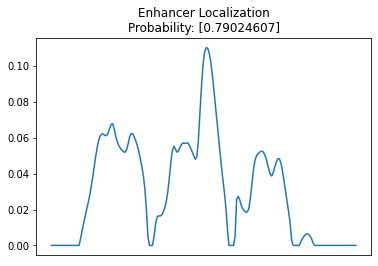

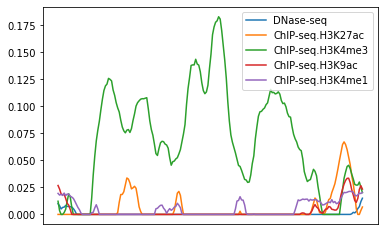

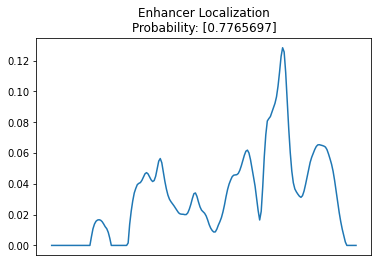

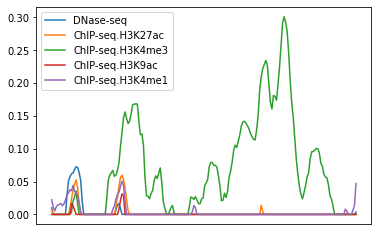

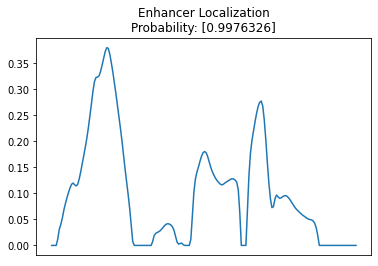

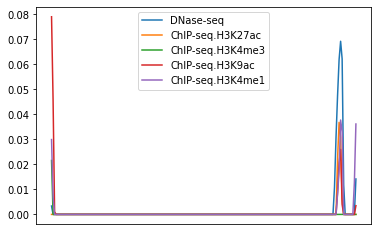

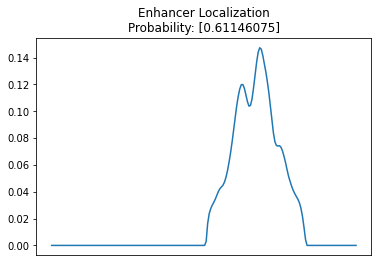

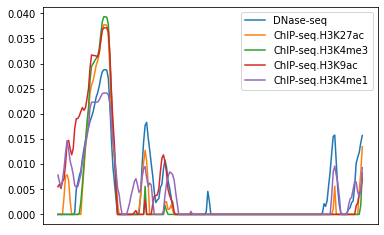

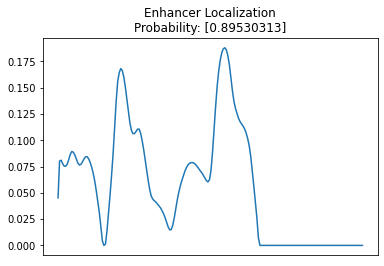

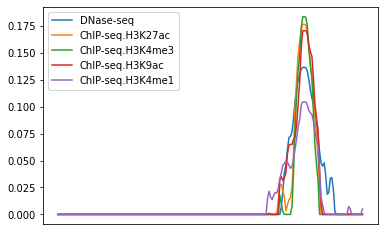

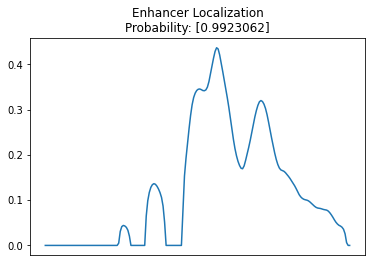

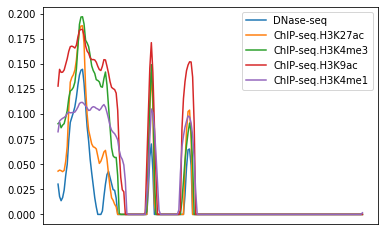

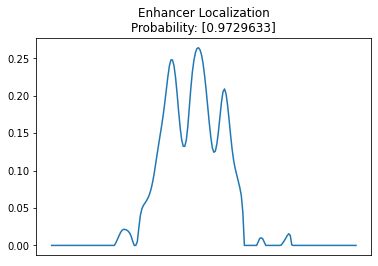

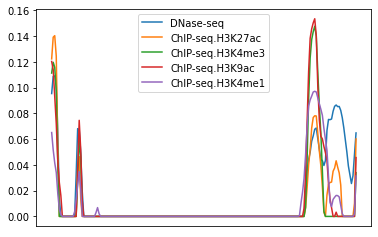

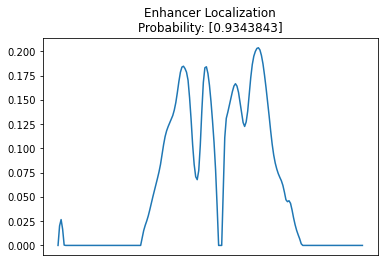

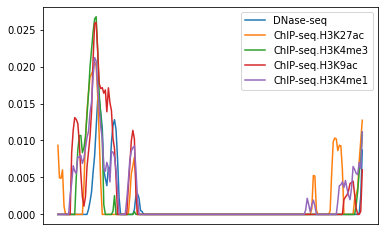

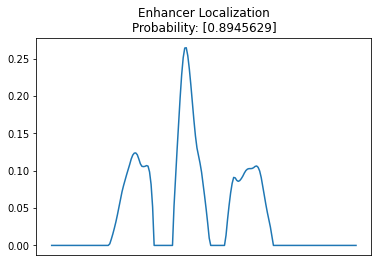

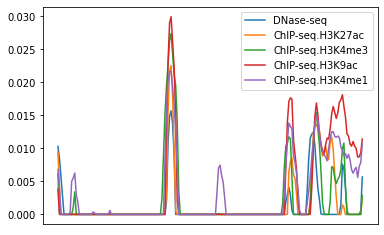

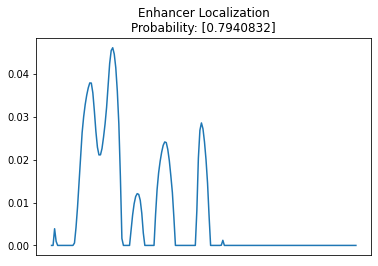

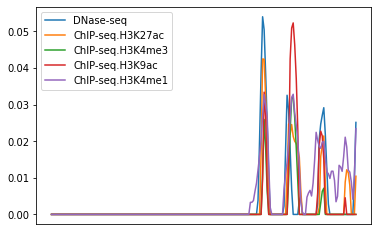

In [13]:
seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]
for idx, item in enumerate(x_pos[:10]):
    plt.title("Enhancer Localization\nProbability: " + str(prediction_results[H1_pos][idx]))
    gradcam_1d = cam_pred_1d(model, np.expand_dims(x_pos[idx], axis=0))[0]
    #norm_gradcam_1d = gradcam_1d / np.max(gradcam_1d)
    plt.plot(gradcam_1d)
    plt.xticks([])
    plt.show();

    cam_5d = cam_pred_5d(model, np.expand_dims(x_pos[idx], axis=0))
    for i in [0,1,2,3,4]:
        plt.plot(cam_5d[i,], label=track_list[i].replace(".bigWig", "").replace("H1.", "").replace(bw_file_dir, ""))
    plt.legend()
    plt.xticks([])
    plt.show();

In [14]:
#define refined regions
predicted_pos = pybedtools.BedTool().window_maker(b="H1.tested_17k_sites.50.prediction.bed", n=int(window_size/10))
print(predicted_pos.count())
predicted_pos.saveas("H1.tested_17k_sites.50.4kb.10bp_bins.bed")

3011600


<BedTool(H1.tested_17k_sites.50.4kb.10bp_bins.bed)>

In [15]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def cam_pred_multi_1d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (int(window_size/10), 1), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam[0])

    all_cam = np.array(all_cam)
    return all_cam

def cam_pred_multi_5d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_3"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (int(window_size/10), 5), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam)

    all_cam = np.array(all_cam)
    return all_cam

#extract 1d grad-cam signal
raw_pred_1d = []
stride = 1000
for i in range(int(len(x_pos)/stride) + 1):
    if (i % 10 == 0):
        print(str(i) + ",000")
    raw_pred_1d.extend(cam_pred_multi_1d(model, x_pos[i * stride: (i+1) * stride]))
raw_pred_1d = np.array(raw_pred_1d)
print(stats.describe(raw_pred_1d.flatten()))

#format into bed with proper regions
df = pd.read_csv("H1.tested_17k_sites.50.4kb.10bp_bins.bed", sep="\t",header=None)
df[4] = raw_pred_1d.flatten()
df.to_csv("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.raw.bed", sep="\t",header=None, index=False)

#refine positive predictions, based on fixed baseline, the mean skews enrichment in a weird way
grad_cam_filter = np.mean(raw_pred_1d.flatten())
# grad_cam_filter = 0.0002
refined_idx = df[4]>grad_cam_filter
df[refined_idx].to_csv("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.filtered.bed", sep="\t",header=None, index=False)
pybedtools.BedTool("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.raw.bed").sort().merge(c=4, o="mean").saveas("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.raw.bed")
pybedtools.BedTool("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.filtered.bed").sort().merge(c=4, o="mean").saveas("H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.filtered.bed")


0,000
DescribeResult(nobs=3011600, minmax=(0.0, 0.87770987), mean=0.026806831, variance=0.0028101285, skewness=3.2978553771972656, kurtosis=15.310542690673625)


<BedTool(H1.tested_17k_sites.50.4kb.10bp_bins.Grad-CAM.filtered.bed)>